In [ ]:
!pip install contractions
!pip install unidecode

     |████████████████████████████████| 327kB 5.2MB/s 
     |████████████████████████████████| 286kB 7.6MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85401 sha256=d4a13331872385fd93ebbfdf5023bd150e910430fe750268234ea802b8187915
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick
     |████████████████████████████████| 245kB 5.0MB/s 


In [ ]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torchtext
from torchtext.legacy.data import Field,LabelField,BucketIterator,TabularDataset
import spacy
from torchtext.data.utils import get_tokenizer
from torch.autograd import Variable
import torch.nn.functional as F
import random
import re
from unidecode import unidecode
import contractions
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
dirs="/content/drive/MyDrive/dataset/Movie_Review_Dataset/"

In [ ]:
data=pd.read_csv("/content/drive/MyDrive/dataset/Movie_Review_Dataset/IMDB Dataset.csv")
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
data["sentiment"]=data["sentiment"].astype('category')

In [ ]:
convert={"positive":1,"negative":0}
data["sentiment"]=data["sentiment"].map(convert)

In [ ]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [ ]:
def remove_html_tags(text):
    """Remove html tags from a string"""
    import re
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

In [ ]:
data["review"]=data["review"].apply(lambda x:remove_html_tags(x))

In [ ]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. The filming tec...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [ ]:
def expend_contraction(txt):
  list_contraction=[]
  for word in txt.split():
    list_contraction.append(contractions.fix(word))

  expend_word=" ".join(list_contraction)
  return expend_word

In [ ]:
data["review"]=data["review"].apply(lambda x:expend_contraction(x))

In [ ]:
data["review"]=data["review"].apply(lambda x:x.lower())

In [ ]:
data["review"]=data["review"].apply(lambda x:unidecode(x))

In [ ]:
data.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production. the filming tec...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there is a family where a little boy...,0
4,"petter mattei's ""love in the time of money"" is...",1


In [ ]:
data["review"]=data["review"].apply(lambda x:re.sub(r'http\S+', '', x))

In [ ]:
data["review"]=data["review"].apply(lambda x:re.sub('[^A-Za-z0-9]+', ' ', x))

In [ ]:
data.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production the filming tech...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there is a family where a little boy...,0
4,petter mattei s love in the time of money is a...,1


In [ ]:
positive=data[data['sentiment']=='positive']
negative=data[data['sentiment']=='negative']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


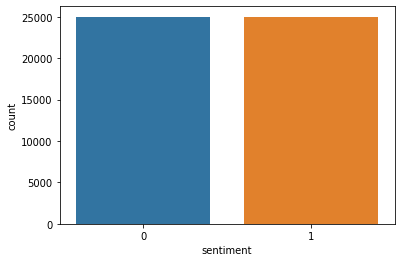

In [ ]:
sns.countplot(data['sentiment'])

In [ ]:
data.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production the filming tech...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there is a family where a little boy...,0
4,petter mattei s love in the time of money is a...,1


In [ ]:
data.to_csv("/content/drive/MyDrive/dataset/Movie_Review_Dataset/Rnn_Dataset.csv",index=False)

###Now We will use n-grams concepts for  in the FastText paper is that they calculate the n-grams

In [ ]:
def generate_bigrams(x):
  n_grams=set(zip(*[x[i:] for i in range(2)]))
  for n_gram in n_grams:
    x.append(" ".join(n_gram))
  return x

In [ ]:
x=['This', 'film', 'is', 'terrible']
generate_bigrams(x)

['This', 'film', 'is', 'terrible', 'This film', 'is terrible', 'film is']

In [ ]:
TEXT=Field(tokenize ='spacy',tokenizer_language = 'en_core_web_sm',preprocessing=generate_bigrams)
Label=LabelField(dtype=torch.float)

In [ ]:
field=[("text",TEXT),("label",Label)]

In [ ]:
training_data=TabularDataset(path="/content/drive/MyDrive/dataset/Movie_Review_Dataset/Rnn_Dataset.csv",format="csv",
                             fields=field,skip_header=True)

print(vars(training_data[3]))

{'text': ['basically', 'there', 'is', 'a', 'family', 'where', 'a', 'little', 'boy', 'jake', 'thinks', 'there', 'is', 'a', 'zombie', 'in', 'his', 'closet', 'his', 'parents', 'are', 'fighting', 'all', 'the', 'time', 'this', 'movie', 'is', 'slower', 'than', 'a', 'soap', 'opera', 'and', 'suddenly', 'jake', 'decides', 'to', 'become', 'rambo', 'and', 'kill', 'the', 'zombie', 'ok', 'first', 'of', 'all', 'when', 'you', 'are', 'going', 'to', 'make', 'a', 'film', 'you', 'must', 'decide', 'if', 'its', 'a', 'thriller', 'or', 'a', 'drama', 'as', 'a', 'drama', 'the', 'movie', 'is', 'watchable', 'parents', 'are', 'divorcing', 'arguing', 'like', 'in', 'real', 'life', 'and', 'then', 'we', 'have', 'jake', 'with', 'his', 'closet', 'which', 'totally', 'ruins', 'all', 'the', 'film', 'i', 'expected', 'to', 'see', 'a', 'boogeyman', 'similar', 'movie', 'and', 'instead', 'i', 'watched', 'a', 'drama', 'with', 'some', 'meaningless', 'thriller', 'spots', '3', 'out', 'of', '10', 'just', 'for', 'the', 'well', 'play

In [ ]:
len(training_data)

50000

In [ ]:
train_data, valid_data = training_data.split(random_state = random.seed(2020))

In [ ]:
len(train_data),len(valid_data)

(35000, 15000)

In [ ]:

MAX_VOCAB_SIZE = 25_000
TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

Label.build_vocab(train_data)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator =BucketIterator.splits(
    (train_data, valid_data), 
    sort_key=lambda x:len(x.text),
    batch_size = BATCH_SIZE, 
    device = device)

In [ ]:
class FastText(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        
        self.fc = nn.Linear(embedding_dim, output_dim)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        
        embedded = self.embedding(text)
                
        #embedded = [sent len, batch size, emb dim]
        
        embedded = embedded.permute(1, 0, 2)
        
        #embedded = [batch size, sent len, emb dim]
        
        pooled = F.avg_pool2d(embedded, (embedded.shape[1], 1)).squeeze(1) 
        
        #pooled = [batch size, embedding_dim]
                
        return self.fc(pooled)

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
OUTPUT_DIM = 1
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = FastText(INPUT_DIM, EMBEDDING_DIM, OUTPUT_DIM, PAD_IDX)
model

FastText(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,500,301 trainable parameters


In [ ]:
pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-1.9343e+00, -4.8510e-01, -1.7537e+00,  ...,  2.9169e-01,
          4.4573e-01,  3.7967e-01],
        [-5.9759e-02,  1.9667e+00,  1.0178e+00,  ...,  1.1866e+00,
          7.0565e-01,  8.8248e-02],
        [-3.8194e-02, -2.4487e-01,  7.2812e-01,  ..., -1.4590e-01,
          8.2780e-01,  2.7062e-01],
        ...,
        [-3.8216e-01, -2.4704e-02, -4.1295e-01,  ..., -1.9052e-01,
         -8.6164e-01, -3.7540e-01],
        [-1.0773e+00,  9.0524e-04,  1.2196e+00,  ..., -1.5881e-01,
          7.8234e-02,  7.8638e-02],
        [ 1.3565e+00, -3.3628e-01,  4.0943e-01,  ...,  1.6566e+00,
          2.4775e-01, -1.0686e-01]])

In [ ]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [ ]:

import torch.optim as optim

optimizer = optim.Adam(model.parameters())

In [ ]:

criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:

N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

  
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    # end_time = time.time()

    # epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), dirs+'saved_weights_1.pt')
    
    # print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

	Train Loss: 0.526 | Train Acc: 82.73%
	 Val. Loss: 0.354 |  Val. Acc: 85.34%
	Train Loss: 0.399 | Train Acc: 87.84%
	 Val. Loss: 0.357 |  Val. Acc: 87.95%
	Train Loss: 0.324 | Train Acc: 89.81%
	 Val. Loss: 0.386 |  Val. Acc: 89.01%
	Train Loss: 0.280 | Train Acc: 90.99%
	 Val. Loss: 0.418 |  Val. Acc: 89.65%
	Train Loss: 0.249 | Train Acc: 91.83%
	 Val. Loss: 0.440 |  Val. Acc: 90.00%


In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

def predict_sentiment(model, sentence):
    model.eval()
    tokenized = generate_bigrams([tok.text for tok in nlp.tokenizer(sentence)])
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    prediction = torch.sigmoid(model(tensor))
    return prediction.item()

In [ ]:
predict_sentiment(model, "This film is terrible")


0.0

In [ ]:
predict_sentiment(model, "This film is great")

1.0

In [ ]:
predict_sentiment(model, "i hate this film")

3.631473941001495e-11

In [ ]:
predict_sentiment(model, "i love this film")

1.0

In [ ]:
predict_sentiment(model, "i love this actor")

1.0

In [ ]:
predict_sentiment(model, "film was amazing")

1.0

In [ ]:
class FastText2(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        
        self.fc = nn.Linear(embedding_dim, output_dim)
        
    def forward(self, text):
        print(text.shape)
        
        #text = [sent len, batch size]
        
        embedded = self.embedding(text)
        print(embedded.shape)        
        #embedded = [sent len, batch size, emb dim]
        
        embedded = embedded.permute(1, 0, 2)
        print(embedded.shape)
        #embedded = [batch size, sent len, emb dim]
        
        pooled = F.avg_pool2d(embedded, (embedded.shape[1], 1)).squeeze(1) 
        print(pooled.shape)
        #pooled = [batch size, embedding_dim]
                
        return self.fc(pooled)

In [ ]:

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
OUTPUT_DIM = 1
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model2 = FastText2(INPUT_DIM, EMBEDDING_DIM, OUTPUT_DIM, PAD_IDX)

In [ ]:
for i in train_iterator:
  model2(i.text)
  break

torch.Size([1473, 64])
torch.Size([1473, 64, 100])
torch.Size([64, 1473, 100])
torch.Size([64, 100])


In [ ]:
class FastText3(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        
        self.fc = nn.Linear(embedding_dim, output_dim)
        
    def forward(self, text):
        print(text.shape)
        
        #text = [sent len, batch size]
        
        embedded = self.embedding(text)
        print(embedded.shape)        
        #embedded = [sent len, batch size, emb dim]
        
        embedded = embedded.permute(1, 0, 2)
        print(embedded.shape)
        #embedded = [batch size, sent len, emb dim]
        
        pooled = F.avg_pool2d(embedded, (embedded.shape[1], 1)).squeeze(1) 
        print(pooled.shape)
        #pooled = [batch size, embedding_dim]
                
        return self.fc(pooled)

In [ ]:
NPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
OUTPUT_DIM = 1
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model3 = FastText3(INPUT_DIM, EMBEDDING_DIM, OUTPUT_DIM, PAD_IDX)

In [ ]:
for i in train_iterator:
  model3(i.text)
  break

torch.Size([1980, 64])
torch.Size([1980, 64, 100])
torch.Size([64, 1980, 100])
torch.Size([64, 100])
